In [28]:
    import numpy as np
    import pandas as pd
    import librosa
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.preprocessing import StandardScaler, LabelEncoder
    from sklearn.model_selection import train_test_split, GridSearchCV, KFold
    from sklearn.metrics import confusion_matrix, classification_report
    import tensorflow as tf
    import joblib

    print("All packages imported successfully!")

All packages imported successfully!


In [29]:
### LOAD Dataset Preprocessing ###

In [45]:
import os
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from scikeras.wrappers import KerasClassifier
from joblib import Parallel, delayed
import warnings

warnings.filterwarnings('ignore')

# Load the dataset
data_path = 'dataset_audio'
ravdess_directory_list = os.listdir(data_path)
print(ravdess_directory_list)

# Prepare lists to hold emotions and file paths
emotions = []
paths = []

# Process each actor directory
for actor in ravdess_directory_list:
    actor_path = os.path.join(data_path, actor)
    
    # Check if the path is a directory
    if not os.path.isdir(actor_path):
        print(f"Skipping {actor_path} as it is not a directory.")
        continue
    
    actor_files = os.listdir(actor_path)

    # Process each audio file in the actor's directory
    for audio_file in actor_files:
        # Check if the file is an audio file
        if not audio_file.endswith('.wav'):
            print(f"Skipping file {audio_file} as it is not a .wav file.")
            continue
        
        # Extract the emotion from the filename
        file_parts = audio_file.split('.')[0].split('-')
        
        # Check if file_parts has enough elements
        if len(file_parts) < 3:
            print(f"Skipping file {audio_file} due to unexpected filename format.")
            continue
        
        emotion_code = int(file_parts[2])

        # Append the emotion and file path to the respective lists
        emotions.append(emotion_code)
        paths.append(os.path.join(actor_path, audio_file))

# Create a DataFrame
data = pd.DataFrame({'Emotion': emotions, 'File_Path': paths})

# Map emotion codes to emotion labels
emotion_map = {
    1: 'neutral', 2: 'calm', 3: 'happy', 4: 'sad', 5: 'angry', 6: 'fearful', 7: 'disgust', 8: 'surprised'
}
data['Emotion'] = data['Emotion'].map(emotion_map)

# Display the DataFrame
print(data.head())
print(f"Total number of data points: {len(data)}")

# Count each emotion
emotion_counts = data['Emotion'].value_counts()
print("\nCount of each emotion:")
print(emotion_counts)



['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']
   Emotion                                        File_Path
0  neutral  dataset_audio\Actor_01\03-01-01-01-01-01-01.wav
1  neutral  dataset_audio\Actor_01\03-01-01-01-01-02-01.wav
2  neutral  dataset_audio\Actor_01\03-01-01-01-02-01-01.wav
3  neutral  dataset_audio\Actor_01\03-01-01-01-02-02-01.wav
4     calm  dataset_audio\Actor_01\03-01-02-01-01-01-01.wav
Total number of data points: 1440

Count of each emotion:
Emotion
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64


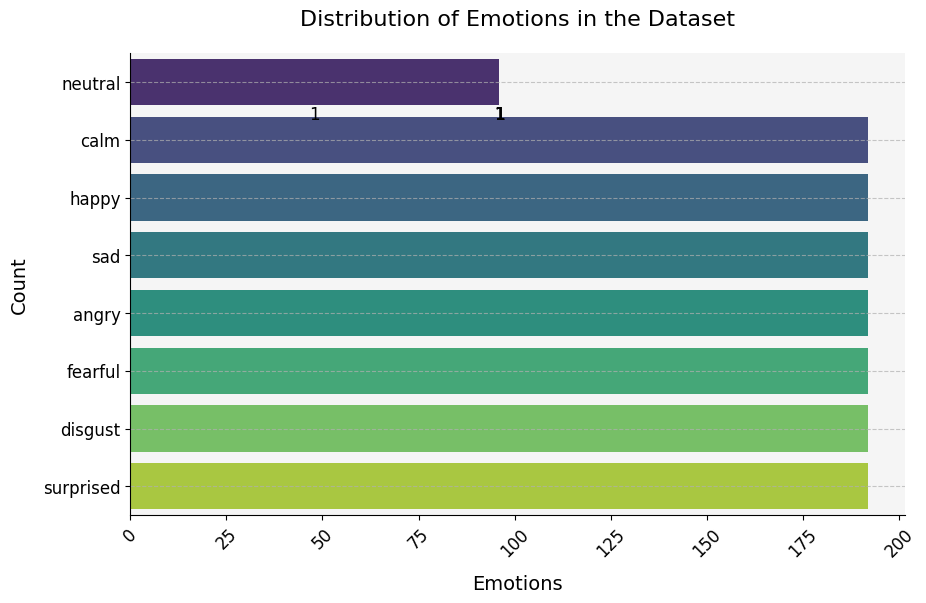

In [31]:
# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
sns.countplot(data['Emotion'], palette='viridis')
plt.title('Distribution of Emotions in the Dataset', fontsize=16, pad=20)
plt.xlabel('Emotions', fontsize=14, labelpad=10)
plt.ylabel('Count', fontsize=14, labelpad=10)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add count labels on each bar
for p in plt.gca().patches:
    plt.gca().annotate(format(p.get_height(), '.0f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha='center', va='center', 
                     xytext=(0, 10), 
                     textcoords='offset points', fontsize=12, color='black')

# Remove top and right spines
sns.despine(top=True, right=True)

# Add gridlines for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a subtle background color
plt.gca().set_facecolor('#f5f5f5')

# Show the plot
plt.show()

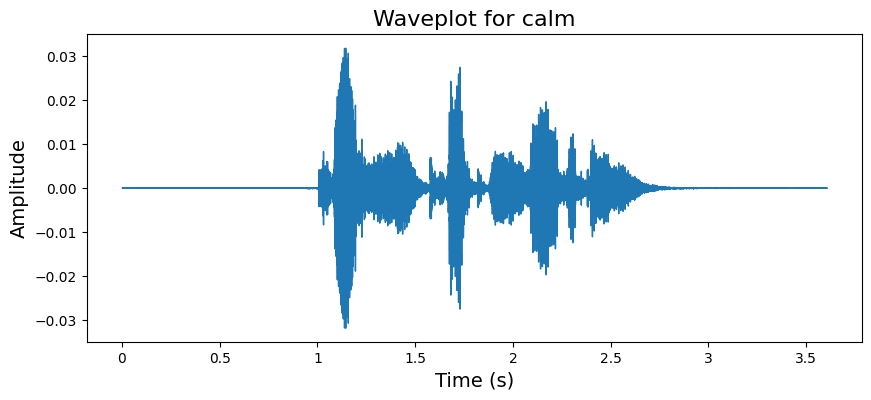

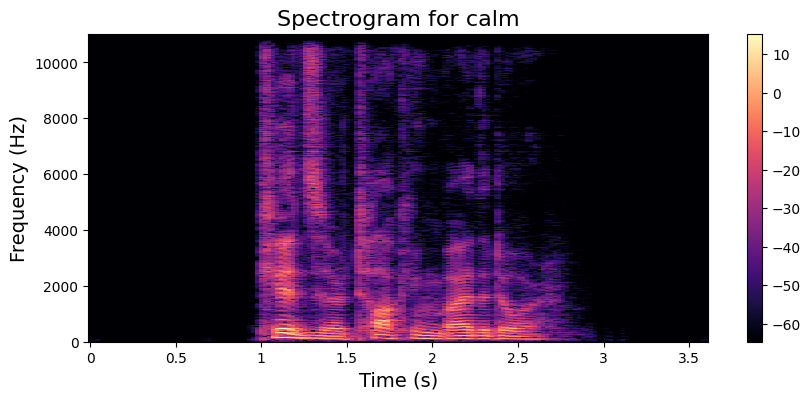

In [39]:
import librosa.display

def preprocess_audio(path):
    # Load audio file
    data, sampling_rate = librosa.load(path)
    
    # Noise reduction
    data = librosa.effects.preemphasis(data)
    
    # Normalize the audio data
    scaler = StandardScaler()
    data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
    
    # Trim silence from the beginning and end
    data, _ = librosa.effects.trim(data)
    
    return data, sampling_rate

# Define the functions to create waveplot and spectrogram
def create_waveplot(data, sampling_rate, emotion):
    plt.figure(figsize=(10, 4))
    plt.title(f'Waveplot for {emotion}', fontsize=16)
    librosa.display.waveshow(data, sr=sampling_rate)
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.show()

def create_spectrogram(data, sampling_rate, emotion):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10, 4))
    plt.title(f'Spectrogram for {emotion}', fontsize=16)
    librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
    plt.colorbar()
    plt.xlabel('Time (s)', fontsize=14)
    plt.ylabel('Frequency (Hz)', fontsize=14)
    plt.show()

# Play the audio file
from IPython.display import Audio

emotion = 'calm'
# Ensure to use the 'data' DataFrame to access paths
path = np.array(data.File_Path[data.Emotion == emotion])[1]
audio_data, sampling_rate = librosa.load(path)

# Create visualizations
create_waveplot(audio_data, sampling_rate, emotion)
create_spectrogram(audio_data, sampling_rate, emotion)

# Play the audio
Audio(path)


In [ ]:
##Feature extraction MFCC##

In [40]:
class FeatureExtractor:
    def __init__(self, frame_length=2048, hop_length=512):
        self.frame_length = frame_length
        self.hop_length = hop_length

    def zcr(self, data):
        return librosa.feature.zero_crossing_rate(data, frame_length=self.frame_length, hop_length=self.hop_length).flatten()

    def rmse(self, data):
        return librosa.feature.rms(y=data, frame_length=self.frame_length, hop_length=self.hop_length).flatten()

    def mfcc(self, data, sr, n_mfcc=13, flatten=True):
        mfcc_features = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=n_mfcc, hop_length=self.hop_length)
        return mfcc_features.T.flatten() if flatten else mfcc_features.T

    def chroma(self, data, sr):
        chroma_features = librosa.feature.chroma_stft(y=data, sr=sr, hop_length=self.hop_length)
        return chroma_features.T.flatten()

    def spectral_contrast(self, data, sr):
        contrast_features = librosa.feature.spectral_contrast(y=data, sr=sr, hop_length=self.hop_length)
        return contrast_features.T.flatten()

    def mel_spectrogram(self, data, sr):
        mel_features = librosa.feature.melspectrogram(y=data, sr=sr, hop_length=self.hop_length)
        return librosa.power_to_db(mel_features).flatten()

    def extract_features(self, data, sr):
        zcr_features = self.zcr(data)
        rmse_features = self.rmse(data)
        mfcc_features = self.mfcc(data, sr)
        chroma_features = self.chroma(data, sr)
        spectral_contrast_features = self.spectral_contrast(data, sr)
        mel_spectrogram_features = self.mel_spectrogram(data, sr)
        return np.concatenate([zcr_features,
                                rmse_features,
                                mfcc_features,
                                chroma_features,
                                spectral_contrast_features,
                                mel_spectrogram_features])

In [ ]:
##Augmentation data###

In [41]:
class DataAugmentation:
    @staticmethod
    def noise(data, noise_factor=0.005):
        noise_amp = noise_factor * np.random.uniform() * np.amax(data)
        return data + noise_amp * np.random.normal(size=data.shape[0])

    @staticmethod
    def pitch(data, sr, n_steps=2):  # Mengurangi jumlah pitch shift
        return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

In [ ]:
### Audio Processor###

In [46]:
class AudioProcessor:
    def __init__(self, frame_length=2048, hop_length=512):
        self.feature_extractor = FeatureExtractor(frame_length, hop_length)
        self.augmenter = DataAugmentation()

    def get_features(self, path, duration=2.5, offset=0.6):
        data, sr = librosa.load(path, duration=duration, offset=offset)
        features = [self.feature_extractor.extract_features(data, sr)]

        # Mengurangi jumlah augmentasi
        noised_audio = self.augmenter.noise(data)
        features.append(self.feature_extractor.extract_features(noised_audio, sr))

        pitched_audio = self.augmenter.pitch(data, sr)
        features.append(self.feature_extractor.extract_features(pitched_audio, sr))

        return np.array(features)

    def process_feature(self, path, emotion):
        features = self.get_features(path)
        X = features.tolist()
        Y = [emotion] * len(features)
        return X, Y

    def process_dataset(self, df, n_jobs=-1):
        paths = df['File_Path'].values
        emotions = df['Emotion'].values

        results = Parallel(n_jobs=n_jobs)(delayed(self.process_feature)(path, emotion) for path, emotion in zip(paths, emotions))

        X, Y = [], []
        for result in results:
            X.extend(result[0])
            Y.extend(result[1])

        # Pad or truncate sequences to the same length
        max_len = max(len(x) for x in X)
        X = np.array([np.pad(x, (0, max_len - len(x)), 'constant') if len(x) < max_len else x[:max_len] for x in X])

        return X, np.array(Y)

In [47]:
# Example usage
processor = AudioProcessor()

# Jumlah data asli
original_data_count = len(data)
print(f"Jumlah data asli: {original_data_count}")

# Hitung jumlah data asli per emosi
original_emotion_counts = data['Emotion'].value_counts()
print("Jumlah data asli per emosi:")
print(original_emotion_counts)

X, Y = processor.process_dataset(data)
print(X.shape, Y.shape)

# Jumlah data setelah augmentasi
augmented_data_count = len(X)
print(f"Jumlah data setelah augmentasi: {augmented_data_count}")

# Buat DataFrame dari data yang telah di-augmentasi
augmented_data = pd.DataFrame({'Emotion': Y})

# Hitung jumlah data setelah augmentasi per emosi
augmented_emotion_counts = augmented_data['Emotion'].value_counts()
print("Jumlah data setelah augmentasi per emosi:")
print(augmented_emotion_counts)

# Hitung pertambahan data per emosi
data_increase_per_emotion = augmented_emotion_counts - original_emotion_counts
print("Jumlah data yang bertambah dari augmentasi per emosi:")
print(data_increase_per_emotion)

Jumlah data asli: 1440
Jumlah data asli per emosi:
Emotion
calm         192
happy        192
sad          192
angry        192
fearful      192
disgust      192
surprised    192
neutral       96
Name: count, dtype: int64
(4320, 17496) (4320,)
Jumlah data setelah augmentasi: 4320
Jumlah data setelah augmentasi per emosi:
Emotion
calm         576
happy        576
sad          576
angry        576
fearful      576
disgust      576
surprised    576
neutral      288
Name: count, dtype: int64
Jumlah data yang bertambah dari augmentasi per emosi:
Emotion
calm         384
happy        384
sad          384
angry        384
fearful      384
disgust      384
surprised    384
neutral      192
Name: count, dtype: int64


In [ ]:
# Periksa apakah setiap data asli menghasilkan tiga data (1 asli + 2 augmentasi)
expected_augmented_data_count = original_data_count * 3
print(f"Jumlah data yang diharapkan setelah augmentasi: {expected_augmented_data_count}")

if augmented_data_count == expected_augmented_data_count:
    print("Augmentasi data berhasil.")
else:
    print("Ada masalah dengan augmentasi data.")

Jumlah data yang diharapkan setelah augmentasi: 4320
Augmentasi data berhasil.


In [ ]:
# Menggunakan subset dari dataset
#subset_data = data.sample(frac=0.5, random_state=42)  # Menggunakan 50% dari dataset asli

def prepare_data_for_cnn(X, Y):
    # Standardize the features
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    joblib.dump(scaler, 'scaler.pkl')

    # Encode the labels
    encoder = LabelEncoder()
    Y = encoder.fit_transform(Y)
    joblib.dump(encoder, 'label_encoder.pkl')

    num_classes = len(np.unique(Y))
    Y = to_categorical(Y, num_classes=num_classes)

    # Split the data into training and testing sets
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

    # Reshape the data for CNN (adding an extra dimension for channels)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1, 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1, 1))

    return X_train, X_test, Y_train, Y_test, num_classes

# Prepare data for CNN
X_train, X_test, Y_train, Y_test, num_classes = prepare_data_for_cnn(X, Y)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(3456, 17496, 1, 1) (3456, 8) (864, 17496, 1, 1) (864, 8)


In [ ]:
param_grid = {
    'batch_size': [32],  
    'epochs': [10, 20],
    'optimizer': ['adam', 'rmsprop']
}

In [ ]:
def build_cnn_model(input_shape, num_classes, optimizer='adam'):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D((2, 1)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 1)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Set dropout rate here
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Wrap the model using KerasClassifier
model = KerasClassifier(build_fn=build_cnn_model, input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), num_classes=num_classes, verbose=0)

# Define the GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(n_splits=3), verbose=1, n_jobs=-1)

# Fit the model
grid_result = grid.fit(X_train, Y_train)

# Print the best parameters and best score
print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Score: {grid_result.best_score_}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'batch_size': 32, 'epochs': 20, 'optimizer': 'adam'}
Best Score: 0.8197337962962963


In [ ]:
# Create the best model with the best parameters
best_params = grid_result.best_params_
best_model = build_cnn_model(input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]), num_classes=num_classes, optimizer=best_params['optimizer'])

# Train the best model
history = best_model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=best_params['epochs'], batch_size=best_params['batch_size'])

# Evaluate the model
accuracy = best_model.evaluate(X_test, Y_test, verbose=0)
print(f'Test Accuracy: {accuracy[1]}')

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 0.2058 - loss: 2.9233 - val_accuracy: 0.3924 - val_loss: 1.6635
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.3441 - loss: 1.6712 - val_accuracy: 0.4745 - val_loss: 1.4658
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 141ms/step - accuracy: 0.4040 - loss: 1.4978 - val_accuracy: 0.5058 - val_loss: 1.3242
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.4768 - loss: 1.3344 - val_accuracy: 0.6759 - val_loss: 1.0683
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 0.5420 - loss: 1.1542 - val_accuracy: 0.7049 - val_loss: 0.9843
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.5730 - loss: 1.0456 - val_accuracy: 0.7384 - val_loss: 0.8728
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.6083 - loss: 0.9551 - val_accuracy: 0.7812 - val_loss: 0.7253
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.6529 - loss: 0

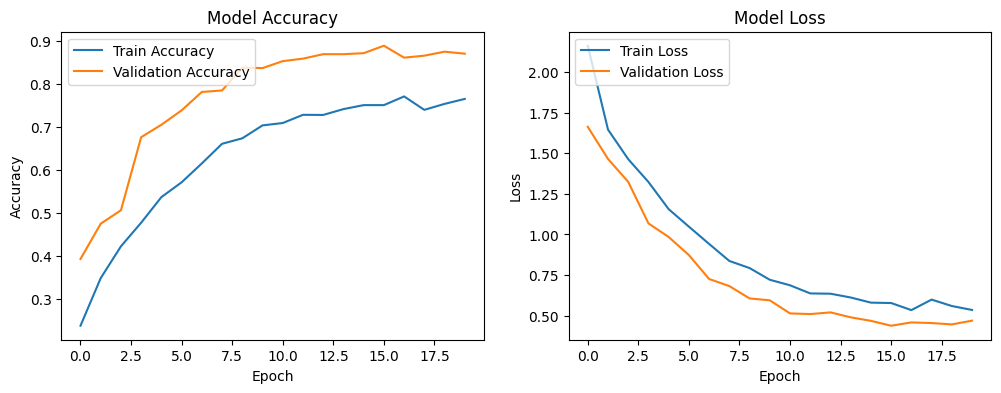

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss values
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper left')

plt.show()

In [ ]:
best_model.save("best_cnn_model.keras")

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


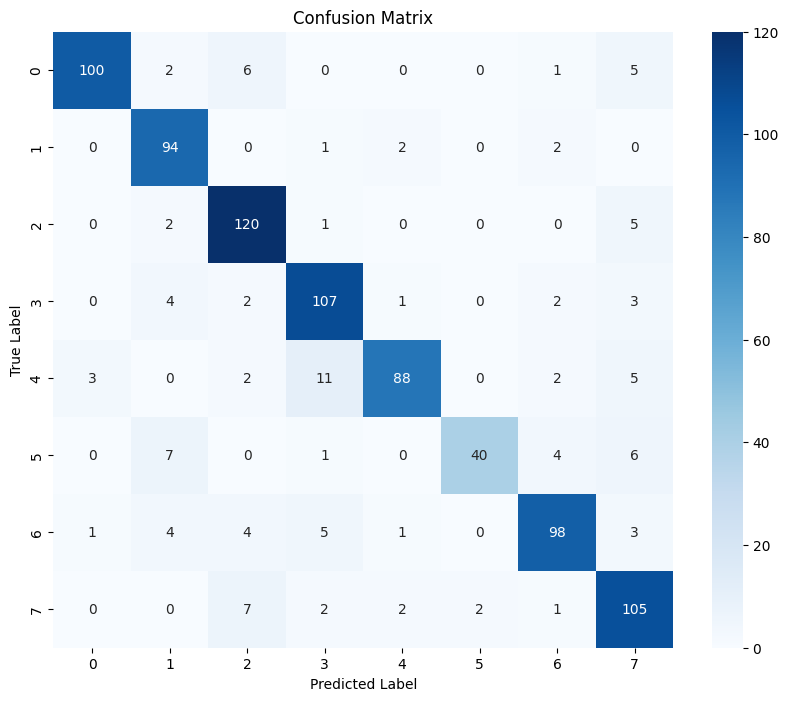

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       114
           1       0.83      0.95      0.89        99
           2       0.85      0.94      0.89       128
           3       0.84      0.90      0.87       119
           4       0.94      0.79      0.86       111
           5       0.95      0.69      0.80        58
           6       0.89      0.84      0.87       116
           7       0.80      0.88      0.84       119

    accuracy                           0.87       864
   macro avg       0.88      0.86      0.87       864
weighted avg       0.88      0.87      0.87       864



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Predict the values from the test set
Y_pred = best_model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(Y_true, Y_pred_classes))